In [1]:
import sys
import os
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/My Drive/10708')
print("Current Working Directory: ", os.getcwdb())

%run Stock_Data.ipynb

Current Working Directory:  b'/content/drive/My Drive/10708'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed
(8315, 7)
                   Open         High          Low    Adj Close      Volume  Log Return       vol
Date                                                                                            
1990-01-02   353.399994   359.690002   351.980011   359.690002   162070000    0.000000       NaN
1990-01-03   359.690002   360.589996   357.890015   358.760010   192330000   -0.258889       NaN
1990-01-04   358.760010   358.760010   352.890015   355.670013   177000000   -0.865030       NaN
1990-01-05   355.670013   355.670013   351.350006   352.200012   158530000   -0.980414       NaN
1990-01-08   352.200012   354.239990   350.540009   353.790009   140110000    0.450431       NaN
...                 ...          ...          ...          ...         ...        

In [4]:
look_back = 1

In [5]:
class LR_DataLoader():
    def __init__(self, dataset, train_ratio, valid_ratio, look_back):
        # Data
        self.data = dataset
        self.extended_data = self.extend_dataset()
        self.features = None
        self.ret_labels = None
        self.close_labels = None
        # split dataset into test-validate-training datasets according to these ratios
        self.train_ratio = train_ratio
        self.valid_ratio = valid_ratio
        # Number of days to look back for return prediction
        self.look_back = look_back

    def extend_dataset(self):
        dataset = self.data

        # calculate volatility
        dataset["10-day-vol"] = dataset["Log Return"].rolling(10).std(ddof=0)

        return dataset


    def build_datasets(self):
        dataset = self.extended_data

        # get the starting index of the usable dataset
        start_index = self.look_back + 30
        
        # build indices
        indices = dataset.index.tolist()[start_index:]
        
        opens = dataset["Open"].values.reshape(-1, 1)
        closes = dataset["Adj Close"].values.reshape(-1, 1)
        highs = dataset["High"].values.reshape(-1, 1)
        lows = dataset["Low"].values.reshape(-1, 1)
        volumes = dataset["Volume"].values.reshape(-1, 1)

        features = opens
        features = np.append(features, closes, axis = 1)
        features = np.append(features, highs, axis = 1)
        features = np.append(features, lows, axis = 1)
        features = np.append(features, volumes, axis = 1)

        # 10-day-vol label
        vol_labels = dataset["10-day-vol"][start_index:].tolist()[10:]
        vol_labels = pd.Series(vol_labels, index=indices[:-10])
        
        # features
        features = features[start_index - self.look_back + 1:]
        # drop the last 10 row as we need 10 days for getting the last label
        features = features[:-10]

        print(features.shape)
        print(vol_labels.shape)

        self.features = features
        self.vol_labels = vol_labels


    def get_datasets(self):
        data_len = self.vol_labels.shape[0]
        train_split = int(data_len * self.train_ratio)
        print('Training Set length - ', str(train_split))

        val_split = train_split + int(data_len * self.valid_ratio)
        print('Validation Set length - ', str(val_split - train_split))

        print('Test Set length - ', str(data_len - val_split))

        # Prepare data
        features = self.features
        vol_labels = self.vol_labels
        
        # Splitting features and labels into train, validation and test samples
        X_train = features[:train_split + self.look_back - 1]
        X_val = features[train_split:val_split + self.look_back - 1]
        X_test = features[val_split:]
        Y_train, Y_val, Y_test = vol_labels[:train_split], vol_labels[train_split:val_split], vol_labels[val_split:]
        
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.Y_test = Y_test

        #print shape of samples
        print(X_train.shape, X_val.shape, X_test.shape)
        print(Y_train.shape, Y_val.shape, Y_test.shape)

In [6]:
LR_DL = LR_DataLoader(raw_data, 0.8, 0.1, look_back)
LR_DL.build_datasets()
LR_DL.get_datasets()

X_train = LR_DL.X_train
X_val = LR_DL.X_val
X_test = LR_DL.X_test

Y_train = LR_DL.Y_train
Y_val = LR_DL.Y_val
Y_test = LR_DL.Y_test


(8274, 5)
(8274,)
Training Set length -  6619
Validation Set length -  827
Test Set length -  828
(6619, 5) (827, 5) (828, 5)
(6619,) (827,) (828,)


In [7]:
# Perform training
lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [8]:
Y_train_pred = lr.predict(X_train)
Y_val_pred = lr.predict(X_val)
Y_test_pred = lr.predict(X_test)

mse:  0.923705681524453


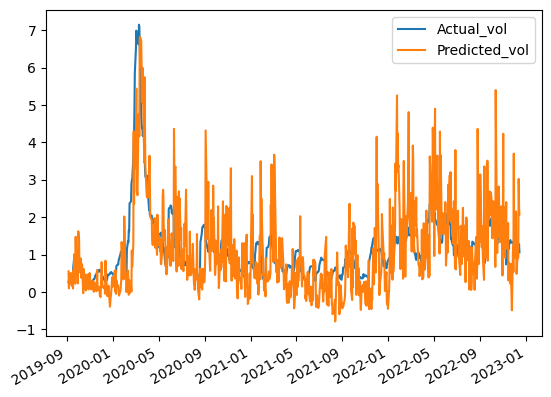

In [9]:
# Plot
vol_pred_label = pd.DataFrame(Y_test.values, columns=["Actual_vol"], index=Y_test.index)
vol_pred_label["Predicted_vol"] = Y_test_pred
vol_pred_label.plot()

mse = mean_squared_error(Y_test.values, Y_test_pred)
print("mse: ", mse)